# Assignment #03 - CNN in Practice - Face Verification


Deep Learning / Fall 1399, Khatam University



---



**Please pay attention to these notes:**
<br><br>



- **Assignment Due:** <b><font color='red'>1399.10.30</font></b> 23:59:00
- If you need any additional information, please review the assignment page on the course website.
- The items you need to answer are highlighted in <font color="purple">**bold purple**</font> and the coding parts you need to implement are denoted by:
```
########################################
#     Put your implementation here     #
########################################
```
- We always recommend co-operation and discussion in groups for assignments. However, **each student has to finish all the questions by him/herself**. If our matching system identifies any sort of copying, you'll be responsible for consequences.
- Students who audit this course should submit their assignments like other students to be qualified for attending the rest of the sessions.
- If you have any questions about this assignment, feel free to drop us a line. You may also post your questions on the course Microsoft Teams channel.
- You must run this notebook on Google Colab platform, it depends on Google Colab VM for some of the depencecies.
- You can double click on collapsed code cells to expand them.
- <b><font color='red'>When you are ready to submit, please follow the instructions at the end of this notebook.</font></b>


<br>



# Introduction

In this assignment we are going to implement **Siamese Network**, a simple neural network architecture for the task of **face recognition**. Also, to get familiar with some CNN visualization methods, we are going to take them into use.
Moreover, in this assignment, you will be using all the TensorFlow features discussed in class.

First, install the assignment requirements by running the cell bellow:

In [ ]:
#@title Install requirements
from IPython.display import clear_output

!pip install gdown
!pip install face_recognition

clear_output()
print ("Done!")

# Dataset

For this assignment, we are going to use **CACD (Cross-Age Celebrity Dataset)** for training our face encoder model, and **LFW (Labeled Faces in the Wild)** dataset for training and testing a simple classifier on our pre-trained encoder network.

Let's download the datasets:



In [ ]:
#@title Download the data
from IPython.display import clear_output

# CACD
!gdown https://drive.google.com/uc?id=1bYou0YJ7HPPelhTgLEcbFzuHMXBPk7Ma
!gdown https://drive.google.com/uc?id=1-LgWh_tVkUg1WZTrVNo7ZSMhtMiZMMfg
!unzip -q /content/CACD_CROP.zip
!mv /content/content/CACD_CROP /content/
!rm -r /content/content
!rm /content/CACD_CROP.zip

# LFW
!gdown https://drive.google.com/uc?id=1-NcVi7iWWCaULY4kvkrJmTD4V4P8kH9v
!unzip -q /content/LFW_CROP.zip
!mv /content/content/LFW_CROP /content/
!rm -r /content/content

!gdown https://drive.google.com/uc?id=1--N8eUgC5-b9tjWIFIRpyM9n1QjXRNcJ
!gdown https://drive.google.com/uc?id=10v99ZYCecCjmRMYL_bITwcd_XtZ7pgM3
!tar -xvf /content/lfw_test_data.tar
!tar -xvf /content/lfw_train_data.tar

!mv /content/content/lfw_test_data.tfds /content/
!mv /content/content/lfw_train_data.tfds /content/
!rm -r /content/content
!rm /content/lfw_test_data.tar
!rm /content/lfw_train_data.tar
!rm /content/LFW_CROP.zip

clear_output()
print ("Done!")

Run the cell below to set the pre-processing configurations of the dataset:

In [ ]:
#@title Data config

# paths
CACD_DIR = "/content/CACD_CROP"
LFW_DIR = "/content/LFW_CROP"

TRIPLES_PATH = "/content/CACD_triples.tsv"
LFW_TF_DATA_TRAIN_DIR = 'lfw_train_data.tfds'
LFW_TF_DATA_TEST_DIR = 'lfw_test_data.tfds'

# Params
INPUT_SIZE = (96, 96) 
BATCH_SIZE = 128 #@param {"type": "integer"}

As you can see in colab's Files panel, we now have some new directories and files:

1.   **lfw_test_data.tfds** and **lfw_train_data.tfds**: TensorFlow dataset. We already have done the required pre-processing steps, therefore these datasets just need to be loaded and they are ready to use.

2.   **CACD_CROP** directory: contains 66950 face cropped image files of celebrities.

3.   **LFW_CROP** directory: contains 11877 face cropped image files of celebrities.

4.   **CACD_triples.tsv** file: contains 100000 triples of the CACD dataset which we are going to later use in triplet loss. Using the following function, we first read and parse this file:

In [ ]:
#@title Read CACD triples
def read_triples(triples_path, images_dir):

  path_anchor, path_positive, path_negative = [], [], []

  with open(triples_path, "r") as f:
    for line in f.read().splitlines():
      
      parts = line.split("\t")
      if len(parts) == 3:
        anchor, positive, negative = parts
      else:
        continue
      path_anchor.append(f'{images_dir}/{anchor}')
      path_positive.append(f'{images_dir}/{positive}')
      path_negative.append(f'{images_dir}/{negative}')
      
  return path_anchor, path_positive, path_negative

triples = read_triples(TRIPLES_PATH, CACD_DIR)

Let's have a look at one of these triples:

In [ ]:
print (f'triples is a {type(triples)} which contains {len(triples)} items.')
print (f'Each item is a {type(triples[0])} which itself contains {len(triples[0])} image paths.')
print (f'Here is a sample triple:')
print (f'{triples[0][0]}\n{triples[1][0]}\n{triples[2][0]}')

As you saw, each triple consists of 3 image paths. We call these images, **anchor**, **positive** and **negative** respectively. The anchor and positive are images of the same person, while the negative is the image of another person. 

Let's have a look at some samples: 

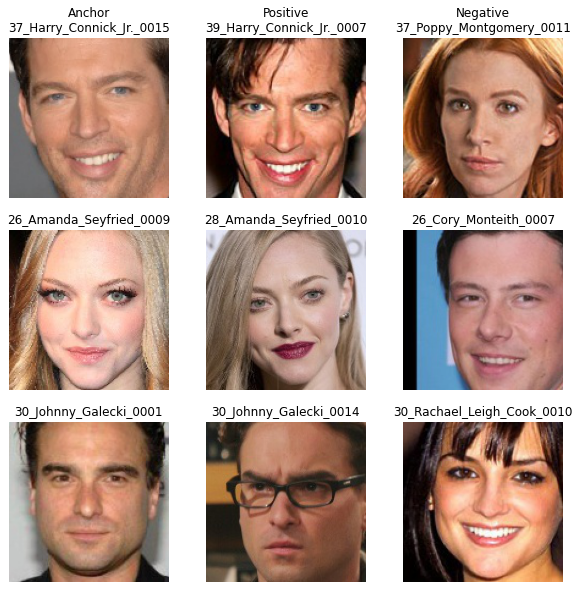

In [ ]:
#@title View sampled triples
import face_recognition as fr
import matplotlib.pyplot as plt
from random import shuffle

fig, ax = plt.subplots(3, 3, figsize=(10,10))
ax[0][0].set_title('Anchor')
ax[0][1].set_title('Positive')
ax[0][2].set_title('Negative')
for i, triple in enumerate(triples):
  for j, name in enumerate(triple[:3]):
    ax[j][i].set_title(ax[j][i].get_title() + '\n'+name[len(CACD_DIR)+1:-4])
    ax[j][i].imshow(fr.load_image_file(name))
    ax[j][i].axis('off')

Now we want to create a TensorFlow dataset using these triples:

We use `from_tensor_slices ` on our `triples` tuple. This will yield a tuple of (anchor_path, positive_path, ngative_path) on each iteration. <font color="purple"><b> Then, we want you to implement the `read_preprocess_image` function which maps these tuple items to processed images. Your implementation must follow these steps:

1.   Read the files using tf.io API
2.   Convert the binary files to jpg images using tf.image API
3.   Resize each image to `INPUT_SIZE` config parameter (look at the config cell above)
4.   Rescale all the integer pixel values in each image from 0-255 to be between -1.0 and 1.0 floating-point values. This step is essential since we are going to use a pre-trained network (mobilenet_v2) in our encoder architecture which has this pre-processing requirement.
5.   Finally, this function returns a tuple of three processed images.



</font></b>
 



In [ ]:
#@title YOUR PART#1 - Make tf data 
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

def read_preprocess_image(*img_paths):
  """Reads images and converts them to image tensor

    Arguments:
    *img_paths: any number of jpg image paths

    Returns:
    A tuple consisting of preocessed image tensors
    with shape=(INPUT_SIZE[0], INPUT_SIZE[1], 3)
  """
  processed_images = []
  for img_path in img_paths:

    ########################################
    #     Put your implementation here     #
    ########################################

  return tuple(processed_images)

def create_tf_dataset(triples, batch_size=BATCH_SIZE, validation_size=5000):

  dataset = tf.data.Dataset.from_tensor_slices(triples)
  dataset = dataset.shuffle(10000, reshuffle_each_iteration=False)
  dataset = dataset.map(read_preprocess_image)

  val_set = dataset.take(validation_size)
  val_set = val_set.shuffle(validation_size, reshuffle_each_iteration=True)
  val_set = val_set.batch(batch_size)
  val_set = val_set.prefetch(buffer_size=AUTOTUNE)

  train_set = dataset.skip(validation_size)
  train_set = train_set.shuffle(10000, reshuffle_each_iteration=True)
  train_set = train_set.batch(batch_size)
  train_set = train_set.prefetch(buffer_size=AUTOTUNE)

  return train_set, val_set

tf_train_data, tf_val_data = create_tf_dataset(triples)

# load LFW tf datasets
lfw_pairs_spec = ((tf.TensorSpec(shape=(*INPUT_SIZE, 3), dtype=tf.float32),
                                    tf.TensorSpec(shape=(*INPUT_SIZE, 3), dtype=tf.float32)),
                                    tf.TensorSpec(shape=(), dtype=tf.int32))

tf_lfw_train_data = tf.data.experimental.load(LFW_TF_DATA_TRAIN_DIR, lfw_pairs_spec).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE) 
tf_lfw_test_data = tf.data.experimental.load(LFW_TF_DATA_TEST_DIR, lfw_pairs_spec).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)                                

print('Done!')

# Model

As mentioned, we are going to use **Siamese Network** for this task. Our final goal is to train an encoder network that makes a meaningful feature vector of the given face image. To achieve this, these are our steps:



*   We first create an encoder architecture.
*   Then We use the **triplet loss** for training our encoder. A triplet contains an **Anchor** image, a **Positive** image, and a **Negative** one. Using our encoder, we first obtain $E_A$, $E_P$, and $E_N$ which are the respective vector representations of our triplet items. Then by minimizing the triplet loss, our model learns to represent anchor and positive samples similarly, while separating them from the negative sample representations. This is how we define this loss:


$$ L(A, P, N) = \max (0, {||E_A - E_P||}^2 - {||E_A - E_N||}^2 + \alpha) $$



**The loss of a batch is computed as the mean loss of all its samples.** $\alpha$ is called the margin. It is a hyperparameter that you pick manually. We will use $\alpha = 0.2$. 

<font color="purple"><b> Now, implement a layer that takes the embeddings as input, and computes the triplet loss: </b><font>

In [ ]:
#@title YOUR PART#2 - TripletLoss layer
from tensorflow.keras.layers import Layer

class TripletLoss(Layer):
    
  def __init__ (self, alpha=0.2):
    super().__init__()
    self.alpha = alpha

  def call(self, anchor, positive, negative):
    
    """ triplet loss

    Arguments:
    anchor, positive, negatuve: batch of image 
    representations

    Returns:
    the calculated triplet loss value
    """


    ########################################
    #     Put your implementation here     #
    ########################################
    
    
    return loss


In [ ]:
#@title check you implementation!
import numpy as np

anchors = tf.constant ([[1.0, 1.0, 1.0],
                       [2.0, 2.0, 2.0]])

positives = tf.constant ([[3.0, 3.0, 3.0],
                         [4.0, 4.0, 4.0]])

negatives = tf.constant ([[0.0, 0.0, 0.0],
                         [6.0, 7.0, 8.0]])

loss = TripletLoss(alpha=5.0)(anchors, positives, negatives)
assert loss.numpy() == 7.0 ,"Wrone Implementation!"
print ("Passed!")

<font color="purple"><b> Explain the role of $\alpha$. What is the difference between a large and a small value of $\alpha$?</b></font>

<font color="purple"><b>##### PUT YOUR ANSWER HERE! #####<b></font>

Now let's create our encoder architecture. It is a common technique to use pre-trained CNN networks as an initializing point. Hence, we are going to use `MobileNetV2` which is a pre-trained model on the imagenet dataset. Also, the first layers of these pre-trained models are mostly responsible for capturing general and non-task specific features of the input image. Therefore, it is usual to freez the early layers of these models since they do not require any further fine-tunig. Let's first load this model and freeze some early layers:

In [ ]:
#@title Load base model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.applications import MobileNetV2, NASNetMobile, EfficientNetB2

base_model = MobileNetV2(input_shape=(*INPUT_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

layer_names = [layer.name for layer in base_model.layers]
target_layer_index = layer_names.index('block_10_expand_relu')
print(f'{target_layer_index} layers of {len(layer_names)} are freezed!')

for layer in base_model.layers[:target_layer_index]:
  layer.trainable = False

base_model.summary()

Our `base_model` output is a batch of 3x3x1280 tensors (`shape = [None, 3, 3, 1280]`). We want our encoder to return a batch of 1d array representations for each image. Therefore, you need to add some layers on top of our `base_model` in order to **compress** and **flatten** its output. 
<font color="purple"><b>Add some suitable layers on top of our `base_model` for this purpose:</font></b>

In [ ]:
#@title YOUR PART#3 - Face encoder architecture


img_input = Input((*INPUT_SIZE, 3))
base_model_output = base_model(img_input)


###### Transform base_model output to a ######
###### dense flat vector representation ######

########################################
#     Put your implementation here     #
########################################

face_encoder = Model(inputs=img_input, outputs=face_embedding, name="face_encoder")  
face_encoder.summary()

In order to train our encoder, we creat another model which takes three images, generates their embeding using our encoder model and computes the triplet loss (note that this model's output is the loss value). 
By minimizing this loss, we implicitly train our encoder:

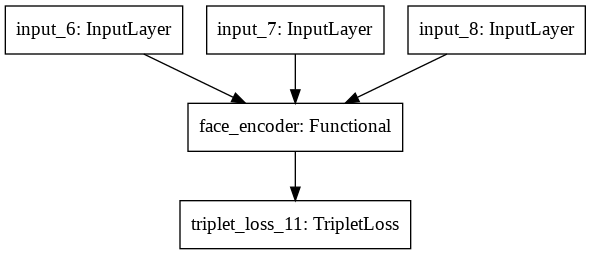

In [ ]:
#@title Face embedding trainer model

input_anchor = Input((*INPUT_SIZE, 3))
input_positive = Input((*INPUT_SIZE, 3))
input_negative = Input((*INPUT_SIZE, 3))

anchor_embedding = face_encoder(input_anchor)
positive_embedding = face_encoder(input_positive)
negative_embedding = face_encoder(input_negative)

ALPHA = 5.0 #@param {"type": "number"}
LEARNING_RATE = 0.0002 #@param {"type": "number"}

loss = TripletLoss(alpha=ALPHA)(anchor_embedding,
                                positive_embedding,
                                negative_embedding)

training_model = Model(inputs=[input_anchor, input_positive, input_negative],
                       outputs=loss)


tf.keras.utils.plot_model(training_model)


We can use the TensorFlow model.fit API to minimize our loss if we want; However, this might be a little tricky and not straight forward. Instead, we are going to use `tf.GradientTape` and a custom training loop that provides full flexibility.

<font color="purple"><b> First, implement the `train_step` function, which takes the input anchor, positive and negative batch of images as input, computes the gradient of the loss with respect to the 'training_model` parameters, applies one step of optimization, and finally returns the value of loss for logging: </font></b>

In [ ]:
#@title YOUR PART#4 - train_step function
from tqdm.notebook import tqdm
import time

optimizer = optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
mean_loss = tf.keras.metrics.Mean(name='train_loss')
mean_val_loss = tf.keras.metrics.Mean(name='val_loss')

@tf.function
def train_step(anchor, positive, negative):

  ########################################
  #     Put your implementation here     #
  ########################################

  return loss

We also implement a validation step function:

In [ ]:
#@title validation_step function
@tf.function
def validation_step(anchor, positive, negative):
  loss = training_model([anchor, positive, negative])
  return loss

In [ ]:
#@title Training loop for face embedding

CHECKPOINT_DIR = "/content/checkpoints" #@param {type:"string"}
EPOCHS = 10 #@param {type:"integer"}

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=training_model)
manager = tf.train.CheckpointManager(
    checkpoint, directory=CHECKPOINT_DIR, max_to_keep=2)

# load checkpoint if available
status = checkpoint.restore(manager.latest_checkpoint)
if status:
  print('No checkpoint found!')
else:
  print(f'Checkpoint loaded from {manager.latest_checkpoint}!')

history = {'loss': [], 'val_loss':[]}

for epoch in range(EPOCHS):

  # reset metrics
  mean_loss.reset_states()
  mean_val_loss.reset_states()

  progress_bar = tqdm(tf_train_data, mininterval=0.5, desc=f'EPOCH {epoch+1}')
  
  # training
  for anchor, positive, negative in progress_bar:
    loss = train_step(anchor, positive, negative)
    mean_loss.update_state(loss)
    progress_bar.set_postfix(loss=loss.numpy())

  # validation
  for anchor, positive, negative in tf_val_data:
    loss = validation_step(anchor, positive, negative)
    mean_val_loss.update_state(loss)

  # recording metric history
  history['loss'].append(mean_loss.result().numpy())
  history['val_loss'].append(mean_val_loss.result().numpy())

  # log to progress bar
  progress_bar.set_postfix(training_loss=history['loss'][-1],
                   validation_loss=history['val_loss'][-1],
                   refresh=True)
  progress_bar.close()

  # save checkpoint
  manager.save()

  # early stoping
  if epoch > 1 and history['val_loss'][-1] >= history['val_loss'][-2]:
    break

After training this model, we just need the encoder part to extract embeddings. Now we put a simple classification layer on top of our embeddings to create a model for the face verification task. In this task, we want to find out whether two given images are of the same person or not.

In order to train and evaluate this classifier we use our LFW train and test datasets:

In [ ]:
#@title Face recognizer model
from tensorflow.keras.layers import Dense

face_encoder.trainable = False

input_1 = Input((*INPUT_SIZE, 3))
input_2 = Input((*INPUT_SIZE, 3))

embedding_1 = face_encoder(input_1)
embedding_2 = face_encoder(input_2)

concat = (embedding_1 - embedding_2) ** 2
output = Dense(1, activation="sigmoid")(concat)
face_recognizer_model = Model(inputs=[input_1, input_2], outputs=output)

LEARNING_RATE = 0.02 #@param {type:"number"}

face_recognizer_model.compile(
    tf.keras.optimizers.Adam(lr=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

history = face_recognizer_model.fit(tf_lfw_train_data, 
                                    validation_data=tf_lfw_test_data,
                                    epochs=50)

If your implementation is correct, you should get around 76% accuracy on the test set, which is an acceptable performance regarding the size of our pre-training dataset!

# Application

There are two possible applications for the model we trained:


*   Having an internal set of verified face images, we can compare an input image to see if it matches any of them or not. In other words we can use this model as an **authentication system**. In order to improve the performance, we could check the input with more than one verified face image for each person.

*   The second possible application of this model, and maybe **a more fun one**, is that we can compare an input image with a set of celebrity face images to see which celebrity has the most similar looks to our input. In this part we are going to do this and find out which celebrity looks like you (or any other person)!
 
BUT, designing and training a high quality face verification model requires much more effort than we could expect in this assignment...

So from now on, we will use a well-known face verification model which applies the core idea of our model. The model is [FaceNet](https://github.com/davidsandberg/facenet) which uses triplet-loss to train its face embeddings and achieves 99% accuracy on LFW dataset.


<font color="purple"><b>What makes FaceNet achieve better peformance than our model? Provide at least two reasons. Obvoiusly you can read about FaceNet from the provided link or any other source.</font></b>

<font color="purple"><b>##### PUT YOUR ANSWER HERE! #####<b></font>

First we load FaceNet model as a keras model. Thanks to [keras-facenet](https://github.com/nyoki-mtl/keras-facenet) we can do this by simply loading model from a h5 file:

In [ ]:
#@title Loading the keras facenet model
import tensorflow as tf
from tensorflow.keras.models import load_model
from IPython.display import clear_output

# download facenet saved model
# !gdown https://drive.google.com/uc?id=1PZ_6Zsy1Vb0s0JmjEmVd8FS99zoMCiN1

# load the model
facenet = load_model('facenet_keras.h5')

clear_output()

print('facenet inputs:', facenet.inputs)
print('facenet outputs:', facenet.outputs)
# facenet.summary()

As you see the model receives an image with shape (160, 160, 3) and outputs its 128-d embedding.

We are going to get face embeddings for all people in LFW dataset. First we should prepare our input images as the model expects.

In [ ]:
#@title List LFW person/images

import os

img_paths = os.listdir(LFW_DIR)
name2image = {}

for img_path in img_paths:
  name = img_path[:img_path.rfind('_')]
  name2image[name] = os.path.join(LFW_DIR, img_path)

names, img_paths = zip(*name2image.items())
img_paths = [path for path in img_paths]
print(f'{len(img_paths)} images are listed.')

We have about 5000 images to process. So it is better to preprocess images using `tf.data` and give them to FaceNet as batches. Again the main part of preprocessing is assigned to you. 

<font color="purple"><b>Complete implementation of `read_preprocess_image_facenet` function which accepts an image path and returns a Tensor with shape (160, 160, 3). It is just like preprocessing for MobileNet, but unlike that, you should standardize pixel values per image, instead of scaling them from  0-255 to [-1, 1]. You can do it easily using a tf operator: `tf.image.per_image_standardization`. Read about what it does in Tensorflow docs.</font></b>

In [ ]:
#@title YOUR PART#5 - Prepare input images for FaceNet

INPUT_SIZE = (160, 160) 

def read_preprocess_image_facenet(img_path):
  """Reads an image file and converts it to image tensor

    Arguments:
    img_path: jpg image path

    Returns:
    preocessed image tensors with shape=(INPUT_SIZE[0], INPUT_SIZE[1], 3)
  """
  
  ########################################
  #     Put your implementation here     #
  ########################################
  
  return img

def create_persons_tf_dataset(img_paths):

  dataset = tf.data.Dataset.from_tensor_slices(img_paths)
  dataset = dataset.map(read_preprocess_image_facenet)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset

tf_single_faces = create_persons_tf_dataset(img_paths)

Having our input images prepared with `tf.data`, we can get face embeddings for all images. But before using these embeddings for comparison, we should normalize them using **L2-Norm** (divide all values by L2-Norm of the vector). This is how FaceNet embeddings are used!

In [ ]:
#@title Get face embeddings for all people
import numpy as np
from tqdm.notebook import tqdm

all_face_embeddings = []

for batch in tqdm(tf_single_faces):
  face_embeddings = facenet(batch, training=False)
  normalized_embeddings = tf.math.l2_normalize(face_embeddings, axis=1)

  for face_embedding in normalized_embeddings:
    all_face_embeddings.append(face_embedding.numpy())

all_face_embeddings = np.array(all_face_embeddings)
print('all face embeddings shape:', all_face_embeddings.shape)

<font color="purple"><b>Now it's your turn to calculate distances between a given input image (face) and all pre-calculated face embeddings. This includes the following steps:

1. Preprocess image for FaceNet (using the function you implemented before)
2. Input image to facenet to get face embedding
3. L2 normalize our embedding
4. Calculate distances using euclidean distance

</b></font>

In [ ]:
#@title YOUR PART#6 - Calculate face distances
def get_face_distances_to(target_img_path, all_face_embeddings):
  """Calculates embedding distance between target image and given embeddings

    Arguments:
    target_img_path: path to target jpg image
    all_face_embeddings: numpy array holding face embeddings 
      with shape= (nummber_of_people, embedding_size)

    Returns:
    Numpy array with shape=(nummber_of_people,) 
      where value at index i, indicates distance between
      target face and the i-th person.
  """
  
  ########################################
  #     Put your implementation here     #
  ########################################
  
  return distances

If your function works properly, continue running next cells to see who is most similar to who?
In the last cell of this part, you can enter url, image path (a sample from our datasets for example) or webcam photo...

In [ ]:
#@title Take photo using webcam
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='me.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
#@title Crop face
import face_recognition
import cv2

def get_face(img_path=None, margin=16, crop=True, show=True):
  """Crops input image to human face, if no input image
  is provided, uses webcam to take photo.

  Arguments:
  img_path: path to target jpg image, None means using webcam as input image
  all_face_embeddings: numpy array holding face embeddings 
    with shape= (nummber_of_people, embedding_size)
  margin: margin used for cropping
  crop: whether or not to crop!
  show: whether or not to show cropped image

  Returns:
  path to output image. it is alway 'my_face.jpg'
  """
  while True:
    img_path = img_path if img_path else take_photo('me.jpg')
    img = face_recognition.load_image_file(img_path)
 
    if crop:
      faces = face_recognition.face_locations(img)
      if len(faces) == 0:
        print('No face found! Capture again...')
        continue

      y1, x2, y2, x1 = faces[0] # top, right, bottom, left
      w = x2 - x1
      h = y2 - y1
      img = img[y1-margin:y2+margin, x1-margin:x2+margin]

    cv2.imwrite('my_face.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    if show:
      plt.axis('off')
      plt.imshow(img)
      plt.show()
    return 'my_face.jpg'

In [ ]:
#@title Who is similar to this?
from IPython.display import clear_output
import matplotlib.pyplot as plt
from urllib.parse import unquote

image_source = "url" #@param ["webcam", "path", "url"]
path = "" #@param {type:"string"}
url = "https://media.elcinema.com/uploads/_315x420_24df4f3635b9316227467b8778f5a457397b6785ccfc2b355cc7f840a3d562e5.jpg" #@param {type:"string"}

similar_count = 7 #@param {type:"integer"}
crop = True #@param {type:"boolean"}

# download image if img_path is a url
img_path = ""
if image_source == "path":
  img_path = path
elif image_source == "url":
  !wget {url}
  url = unquote(url)
  img_path = url[url.rfind('/')+1:]
  clear_output()

# crop image to face
target_face_path = get_face(img_path, margin=16, crop=crop, show=True)

# calculate distances
distances = get_face_distances_to(target_face_path, all_face_embeddings)

# sort names, images by distance
sort_indexes = np.argsort(distances)
similar_names = [names[i] for i in sort_indexes]
similar_images = [img_paths[i] for i in sort_indexes]
distances = distances[sort_indexes]

# show most similar images
fig, ax = plt.subplots(1, similar_count, figsize=(similar_count*3,5))
fig.suptitle('Most Similar', fontsize=24, y=0.90)
images = [face_recognition.load_image_file(path) for path in similar_images[:similar_count]]
for i, (img, name, dist) in enumerate(zip(images, similar_names, distances)):
  ax[i].set_title(f'{name}\ndist={dist:.3}')
  ax[i].imshow(img)
  ax[i].axis('off')

fig.show()

# Interpretation

In this segment, we are going to take a small step towards model interpretation. One of simplest methods used to explain behaviour of deep neural networks is to check gradient of model output with respect to its input features. This method is called **gradient saliency**, which represents saliency of each feature for producing model output.

Here in face verification, the inputs features are image pixels and the output is defference between two faces.

In [ ]:
#@title Read matching pair of faces


def read_matching_pairs(cacd_path, images_dir):

  pairs = []

  with open(cacd_path, "r") as f:
    for line in f.read().splitlines():
      
      parts = line.split("\t")
      if len(parts) == 3:
        anchor, positive, negative = parts
      else:
        continue
      pairs.append((f'{images_dir}/{anchor}', f'{images_dir}/{positive}'))
      
  return pairs

matching_pairs = read_matching_pairs(TRIPLES_PATH, CACD_DIR)

i = 2 #@param {type:"integer"}

matching_pair = matching_pairs[i]
img0 = read_preprocess_image_facenet(matching_pair[0])
img1 = read_preprocess_image_facenet(matching_pair[1])

Here the core part is up to you!

<font color="purple"><b>Implement function `compute_gradients` which takses as input two image tensors. gets embedding for both using facenet. And calculates euclidean distance between L2-normalized embeddings. And finally returns a tuple:
(euclidean distance, gradient of euclidean distance wrt. both images)

Notes:
1. You should use `tf.GradientTape` here!
2. The inputs are Variable Tensors so you don't need to explicitly watch them by gradient tape.
3. The shape of gradients should be same as input images.

</b></font>

In [ ]:
#@title YOUR PART#7 - Compute gradient saliency

def compute_gradients(img0, img1):
  """
  Computes gradient of eucliean distance between two image embeddings, 
  with respect to the input images

  Arguments:
  img0: first image as a Variable Tensor
  img0: second image as a Variable Tensor

  Returns: A tuple containing
  euclidean distance between embeddings, gradients of distance wrt. both input images
  """


  ########################################
  #     Put your implementation here     #
  ########################################

  return distance, gradients 

v0 = tf.Variable(img0, dtype=float)
v1 = tf.Variable(img1, dtype=float)

distance, gradients = compute_gradients(v0, v1)
print('distance:', distance)
print('gradients shape:', gradients[0].shape, gradients[1].shape)

Raw gradients for input images are very noisy and hard to interpret. We took mean value along channels and then applied blur effect on absolute gradient values. Finally original image pixels are multiplied by their blurred amplified gradients to make these plots:

In [ ]:
#@title Plot gradients

from matplotlib import colors
import numpy as np
import cv2

pair_number = 2 #@param {type:"integer"}
blur_size = 16 #@param {type:"integer"}

matching_pair = matching_pairs[pair_number]
img0 = read_preprocess_image_facenet(matching_pair[0])
img1 = read_preprocess_image_facenet(matching_pair[1])

v0 = tf.Variable(img0, dtype=float)
v1 = tf.Variable(img1, dtype=float)

diff, grads = compute_gradients(v0, v1)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# fig.suptitle(labels[i].numpy() > 0, fontsize=24)
fig.suptitle("Distance: " + str(diff.numpy()), fontsize=24)

proccesed_grad_0 = grads[0].numpy().mean(axis=-1)   # mean grads along channals axis
proccesed_grad_0 /= np.abs(proccesed_grad_0.max())  # normalize grads values
np_img0 = img0.numpy()
np_img0 = (np_img0 - np_img0.min())/(np_img0.max()-np_img0.min())
ax[0][0].imshow(np_img0)

proccesed_grad_0 = cv2.blur(np.abs(proccesed_grad_0), (blur_size, blur_size))   # blur grads
ax[0][0].axis('off')

proccesed_grad_1 = grads[1].numpy().mean(axis=-1)   # mean grads along channals axis
proccesed_grad_1 /= np.abs(proccesed_grad_1.max())  # normalize grads values
np_img1 = img1.numpy()
np_img1 = (np_img1 - np_img1.min())/(np_img1.max()-np_img1.min())
ax[0][1].imshow(np_img1)

proccesed_grad_1 = cv2.blur(np.abs(proccesed_grad_1), (blur_size, blur_size))   # blur grads
ax[0][1].axis('off')

ax[1][0].imshow(np.clip(np_img0 * np.expand_dims(proccesed_grad_0, axis=-1)*2/proccesed_grad_0.max(), 0, 1))
ax[1][0].axis('off')
ax[1][1].imshow(np.clip(np_img1 * np.expand_dims(proccesed_grad_1, axis=-1)*2/proccesed_grad_1.max(), 0, 1))
ax[1][1].axis('off')

fig.show()


<font color="purple"><b>Try visualizing gradient saliency for some pairs, and interpret (explain) the model behaviour based on your observations.
</b></font>

<font color="purple"><b>##### PUT YOUR ANSWER HERE! #####<b></font>

# Submission

Congratulations! You finished the assignment & you're ready to submit your work. Please follow the instructions:

1. Check and review your answers. Make sure all of the cell outputs are what you want. 
2. Select File > Save.
3. **Fill your information** & run the cell bellow.
4. Run **Make Submission** cell, It may take several minutes and it may ask you for your credential.
5. Run **Download Submission** cell to obtain your submission as a zip file.
6. Grab the downloaded file (`dl_asg03__xx__xx.zip`) and hand it over in microsoft teams.

## Fill your information (Run the cell)

In [ ]:
#@title Enter your information & "RUN the cell!!" { run: "auto" }
student_id = "" #@param {type:"string"}
student_name = "" #@param {type:"string"}

print("your student id:", student_id)
print("your name:", student_name)


from pathlib import Path

ASSIGNMENT_PATH = Path('asg03')
ASSIGNMENT_PATH.mkdir(parents=True, exist_ok=True)

## Make Submission (Run the cell)

In [ ]:
#@title Make submission
! pip install -U --quiet PyDrive > /dev/null
! pip install -U --quiet jdatetime > /dev/null

# ! wget -q https://github.com/github/hub/releases/download/v2.10.0/hub-linux-amd64-2.10.0.tgz 


import os
import time
import yaml
import json
import jdatetime

from google.colab import files
from IPython.display import Javascript
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

asg_name = 'Assignment_3'
script_save = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
# repo_name = 'iust-deep-learning-assignments'
submission_file_name = 'dl_asg03__%s__%s.zip'%(student_id, student_name.lower().replace(' ',  '_'))

sub_info = {
    'student_id': student_id,
    'student_name': student_name, 
    'dateime': str(jdatetime.date.today()),
    'asg_name': asg_name
}
json.dump(sub_info, open('info.json', 'w'))

Javascript(script_save)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = drive.ListFile({'q':"title='%s.ipynb'"%asg_name}).GetList()[0]['id']
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('%s.ipynb'%asg_name) 

! jupyter nbconvert --to script "$asg_name".ipynb > /dev/null
! jupyter nbconvert --to html "$asg_name".ipynb > /dev/null
! zip "$submission_file_name" "$asg_name".ipynb "$asg_name".html "$asg_name".txt info.json > /dev/null

print("##########################################")
print("Done! Submisson created, Please download using the bellow cell!")

In [4]:
files.download(submission_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>